In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import yaml

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
# Load data from all wandb runs
wandb_dir = Path('results/wandb')
runs_data = []

for run_dir in wandb_dir.iterdir():
    if run_dir.is_dir() and run_dir.name.startswith('run-'):
        summary_file = run_dir / 'files' / 'wandb-summary.json'
        config_file = run_dir / 'files' / 'config.yaml'
        
        if summary_file.exists() and config_file.exists():
            with open(summary_file, 'r') as f:
                summary = json.load(f)
            
            with open(config_file, 'r') as f:
                config = yaml.safe_load(f)
            
            # Extract key metrics
            run_info = {
                'run_id': run_dir.name,
                'test_acc': summary.get('test_acc', summary.get('summary/test_acc')),
                'test_loss': summary.get('test_loss', summary.get('summary/test_loss')),
                'val_acc': summary.get('val_acc'),
                'val_loss': summary.get('val_loss'),
                'train_acc': summary.get('train_acc'),
                'train_loss': summary.get('train_loss'),
                'best_val_acc': summary.get('best_val_acc', summary.get('summary/best_val_acc')),
                'best_epoch': summary.get('best_epoch'),
                'runtime': summary.get('_runtime', summary.get('_wandb', {}).get('runtime')),
                'learning_rate': config.get('learning_rate', {}).get('value'),
                'batch_size': config.get('batch_size', {}).get('value'),
                'dropout': config.get('dropout', {}).get('value'),
                'weight_decay': config.get('weight_decay', {}).get('value'),
                'optimizer': config.get('optimizer', {}).get('value'),
                'architecture': config.get('architecture', {}).get('value'),
                'improvements': config.get('improvements', {}).get('value', '')
            }
            runs_data.append(run_info)

# Create DataFrame
df = pd.DataFrame(runs_data)
# Remove runs with missing critical data
df = df.dropna(subset=['test_acc', 'test_loss'])
print(f"Loaded {len(df)} complete runs")
df.head()

Loaded 8 complete runs


,run_id,test_acc,test_loss,val_acc,val_loss,train_acc,train_loss,best_val_acc,best_epoch,runtime,learning_rate,batch_size,dropout,weight_decay,optimizer,architecture,improvements
2,run-20251215_150045-fg3yp8lj,68.3,0.590051,69.090909,0.555086,81.022727,0.428269,69.772727,13.0,266.467655,0.0001,32,None,0.0005,Adam,Siamese Network,
3,run-20251219_183432-9ou6x57u,72.9,0.816390,73.409091,0.746376,98.977273,0.041942,75.000000,12.0,287.404680,0.0001,32,None,0.0005,Adam,Siamese Network with BatchNorm + Multi-channel...,"BatchNorm, Multi-channel similarity head, Redu..."
7,run-20251219_185512-nlg0husq,54.1,0.683732,52.272727,0.680239,53.238636,0.745672,53.409091,6.0,166.805869,0.0001,32,None,0.0010,Adam,Siamese Network with BatchNorm + Multi-channel...,"All 3: Very strong dropout (0.7 FC, 0.6 simila..."
9,run-20251219_191944-5lh7ez2v,63.2,0.641880,63.636364,0.640372,57.670455,0.676639,67.045455,15.0,258.331906,0.0001,32,None,0.0010,Adam,Siamese Network with BatchNorm + Multi-channel...,"BASELINE: Light dropout (0.3 FC/similarity, 0...."
11,run-20251219_192927-rcjzlbbw,68.3,0.590051,69.090909,0.555086,81.022727,0.428269,69.772727,13.0,262.828185,0.0001,32,None,0.0005,Adam,Siamese Network,


## a. Convergence Times, Final Loss and Accuracy

Metrics across all runs in chronological order.

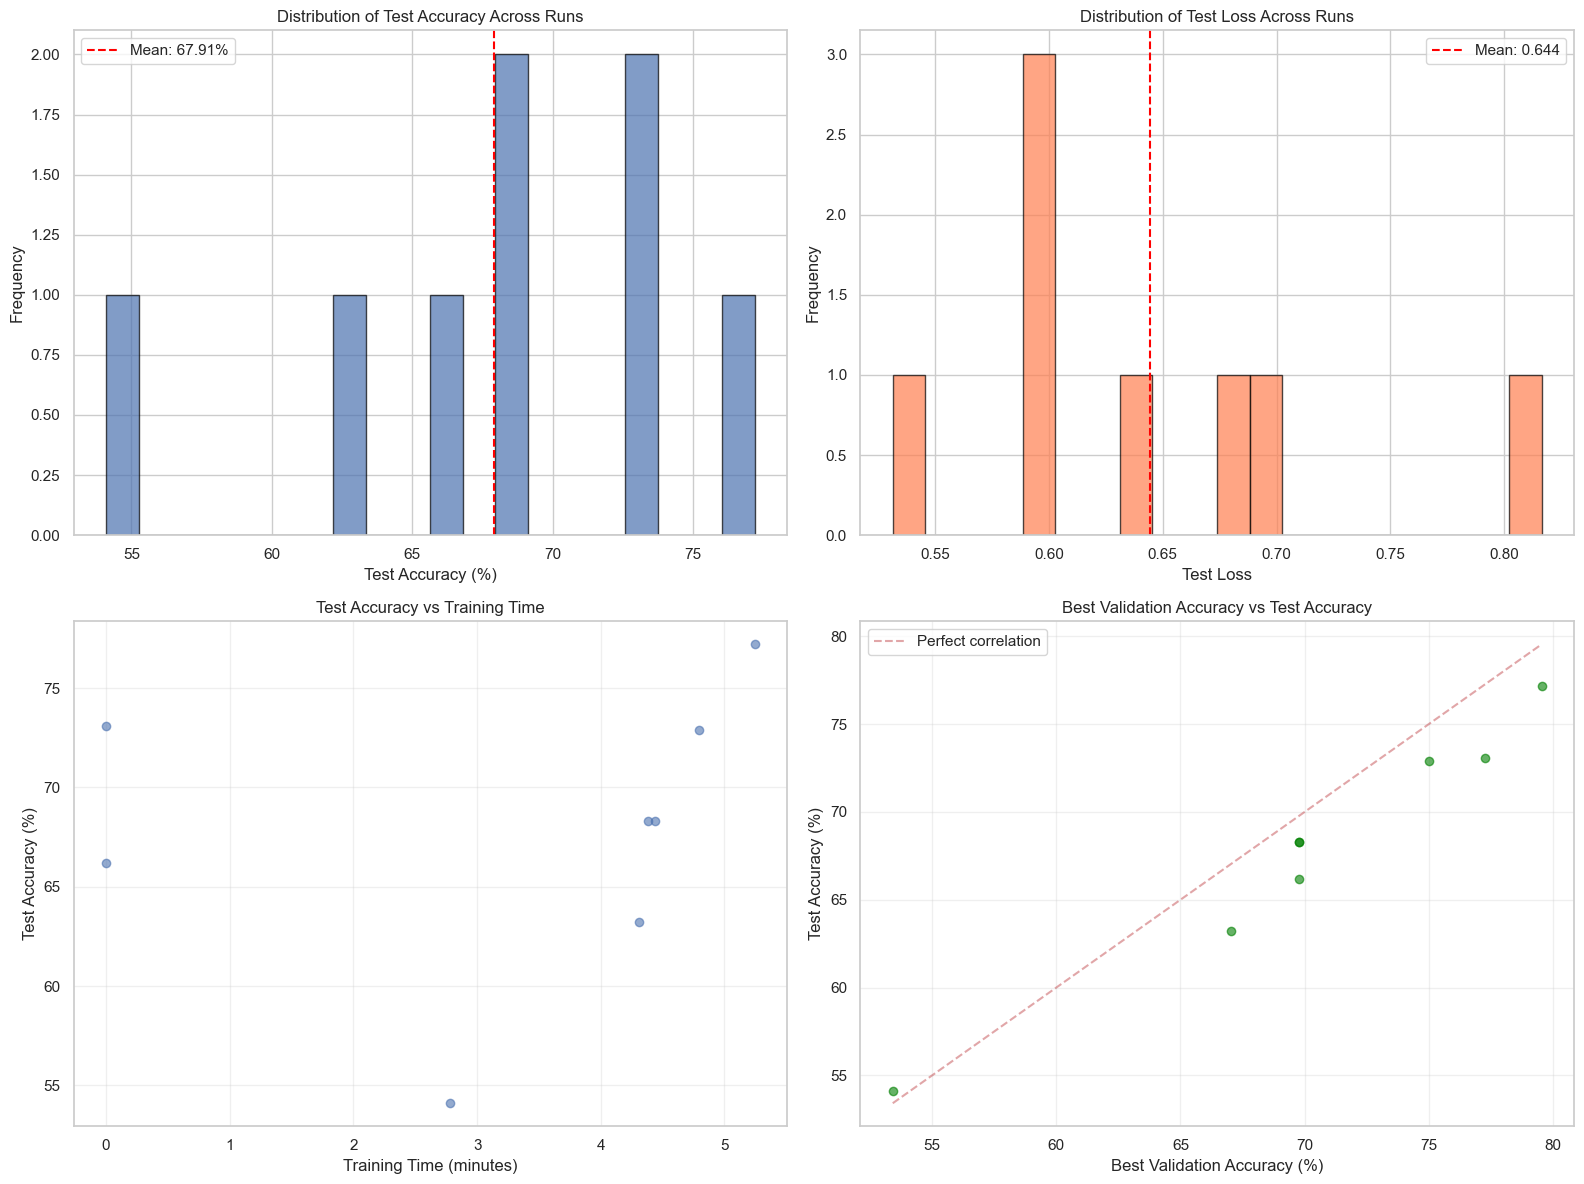


=== Summary Statistics ===
Best Test Accuracy: 77.20%
Mean Test Accuracy: 67.91% (±7.11%)
Best Test Loss: 0.5314
Mean Test Loss: 0.6444 (±0.0887)
Average Training Time: 3.24 minutes


In [ ]:
# Sort runs chronologically by run_id (contains timestamp)
df_sorted = df.sort_values('run_id').reset_index(drop=True)
run_numbers = range(1, len(df_sorted) + 1)

# Create plots with runs on x-axis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Test Accuracy Across Runs
axes[0, 0].plot(run_numbers, df_sorted['test_acc'], marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_xlabel('Run Number (Chronological)', fontsize=12)
axes[0, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[0, 0].set_title('Test Accuracy Across Runs', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(df_sorted['test_acc'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {df_sorted["test_acc"].mean():.2f}%')
axes[0, 0].legend()

# 2. Test Loss Across Runs
axes[0, 1].plot(run_numbers, df_sorted['test_loss'], marker='s', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
axes[0, 1].set_ylabel('Test Loss', fontsize=12)
axes[0, 1].set_title('Test Loss Across Runs', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(df_sorted['test_loss'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {df_sorted["test_loss"].mean():.3f}')
axes[0, 1].legend()

# 3. Validation and Test Accuracy Comparison
val_data = df_sorted[df_sorted['val_acc'].notna()]
val_run_numbers = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'val_acc'] == df_sorted.loc[idx, 'val_acc']]
axes[1, 0].plot(run_numbers, df_sorted['test_acc'], marker='o', linewidth=2, markersize=8, label='Test Accuracy', color='#2E86AB')
if not val_data.empty:
    axes[1, 0].plot(val_run_numbers, val_data['val_acc'], marker='^', linewidth=2, markersize=8, label='Validation Accuracy', color='#F18F01')
axes[1, 0].set_xlabel('Run Number (Chronological)', fontsize=12)
axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Test vs Validation Accuracy Across Runs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Training Time (Runtime) Across Runs
runtime_data = df_sorted[df_sorted['runtime'].notna()]
if not runtime_data.empty:
    runtime_run_numbers = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'runtime'] == df_sorted.loc[idx, 'runtime']]
    axes[1, 1].plot(runtime_run_numbers, runtime_data['runtime'] / 60, marker='D', linewidth=2, markersize=8, color='#C73E1D')
    axes[1, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[1, 1].set_ylabel('Training Time (minutes)', fontsize=12)
    axes[1, 1].set_title('Training Time Across Runs', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(runtime_data['runtime'].mean() / 60, color='red', linestyle='--', alpha=0.7, 
                       label=f'Mean: {runtime_data["runtime"].mean() / 60:.2f} min')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No runtime data available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[1, 1].set_ylabel('Training Time (minutes)', fontsize=12)
    axes[1, 1].set_title('Training Time Across Runs', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/convergence_and_final_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Total Runs: {len(df_sorted)}")
print(f"Best Test Accuracy: {df_sorted['test_acc'].max():.2f}% (Run #{df_sorted['test_acc'].idxmax() + 1})")
print(f"Mean Test Accuracy: {df_sorted['test_acc'].mean():.2f}% (±{df_sorted['test_acc'].std():.2f}%)")
print(f"Best Test Loss: {df_sorted['test_loss'].min():.4f} (Run #{df_sorted['test_loss'].idxmin() + 1})")
print(f"Mean Test Loss: {df_sorted['test_loss'].mean():.4f} (±{df_sorted['test_loss'].std():.4f})")
if not runtime_data.empty:
    print(f"Average Training Time: {runtime_data['runtime'].mean() / 60:.2f} minutes")

## b. Training Loss Throughout Training Process

Visualizing loss curves from the best performing runs.

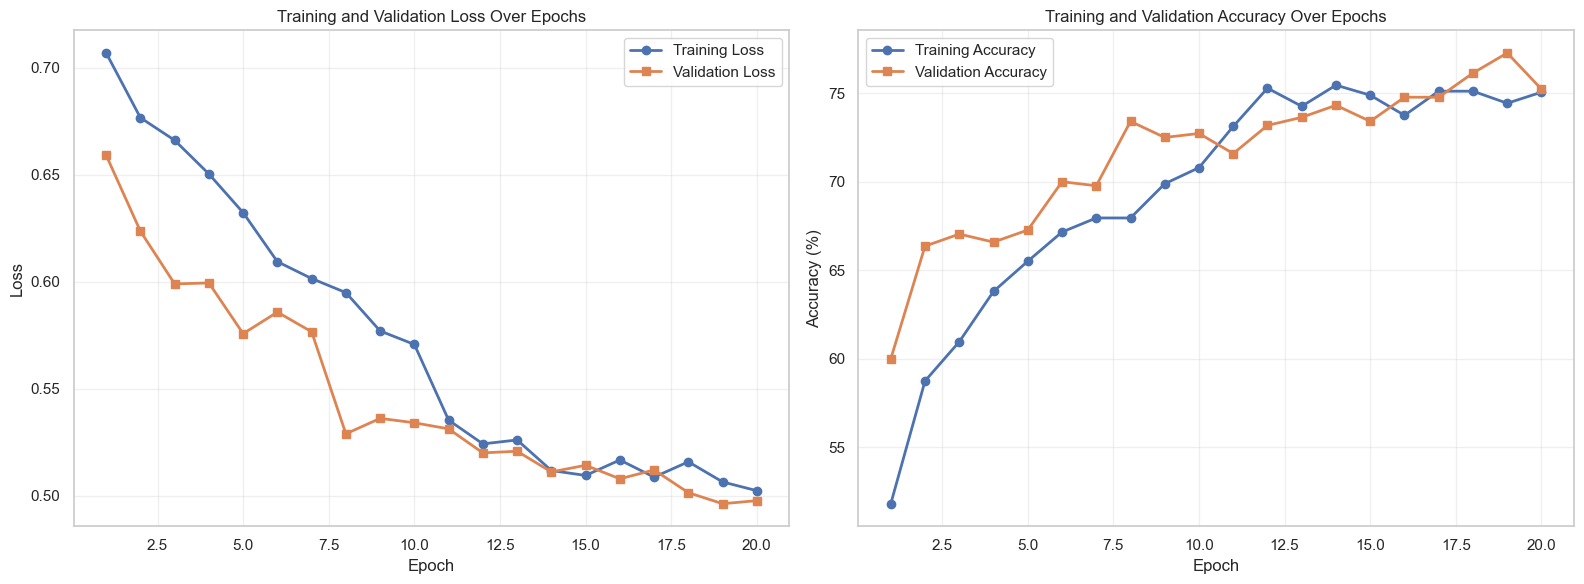


Best Validation Accuracy: 77.27%
Final Test Accuracy: 73.10%
Final Test Loss: 0.5314


In [4]:
# Load training results JSON for detailed training history
training_results_file = Path('results/training_results.json')

if training_results_file.exists():
    with open(training_results_file, 'r') as f:
        training_results = json.load(f)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training and Validation Loss
    epochs = range(1, len(training_results['training_history']['train_loss']) + 1)
    
    axes[0].plot(epochs, training_results['training_history']['train_loss'], 
                 label='Training Loss', marker='o', linewidth=2)
    axes[0].plot(epochs, training_results['training_history']['val_loss'], 
                 label='Validation Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss Over Epochs')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training and Validation Accuracy
    axes[1].plot(epochs, training_results['training_history']['train_acc'], 
                 label='Training Accuracy', marker='o', linewidth=2)
    axes[1].plot(epochs, training_results['training_history']['val_acc'], 
                 label='Validation Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy Over Epochs')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nBest Validation Accuracy: {training_results['results']['best_val_acc']:.2f}%")
    print(f"Final Test Accuracy: {training_results['results']['test_acc']:.2f}%")
    print(f"Final Test Loss: {training_results['results']['test_loss']:.4f}")
else:
    print("Training results file not found. Skipping detailed training curves.")

## c. Performance with Various Parameters

Analyzing how different hyperparameters affect model performance across runs.

C:\Users\orimood\AppData\Local\Temp\ipykernel_15924\1007640905.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropout_df['dropout_numeric'] = pd.to_numeric(dropout_df['dropout'], errors='coerce')


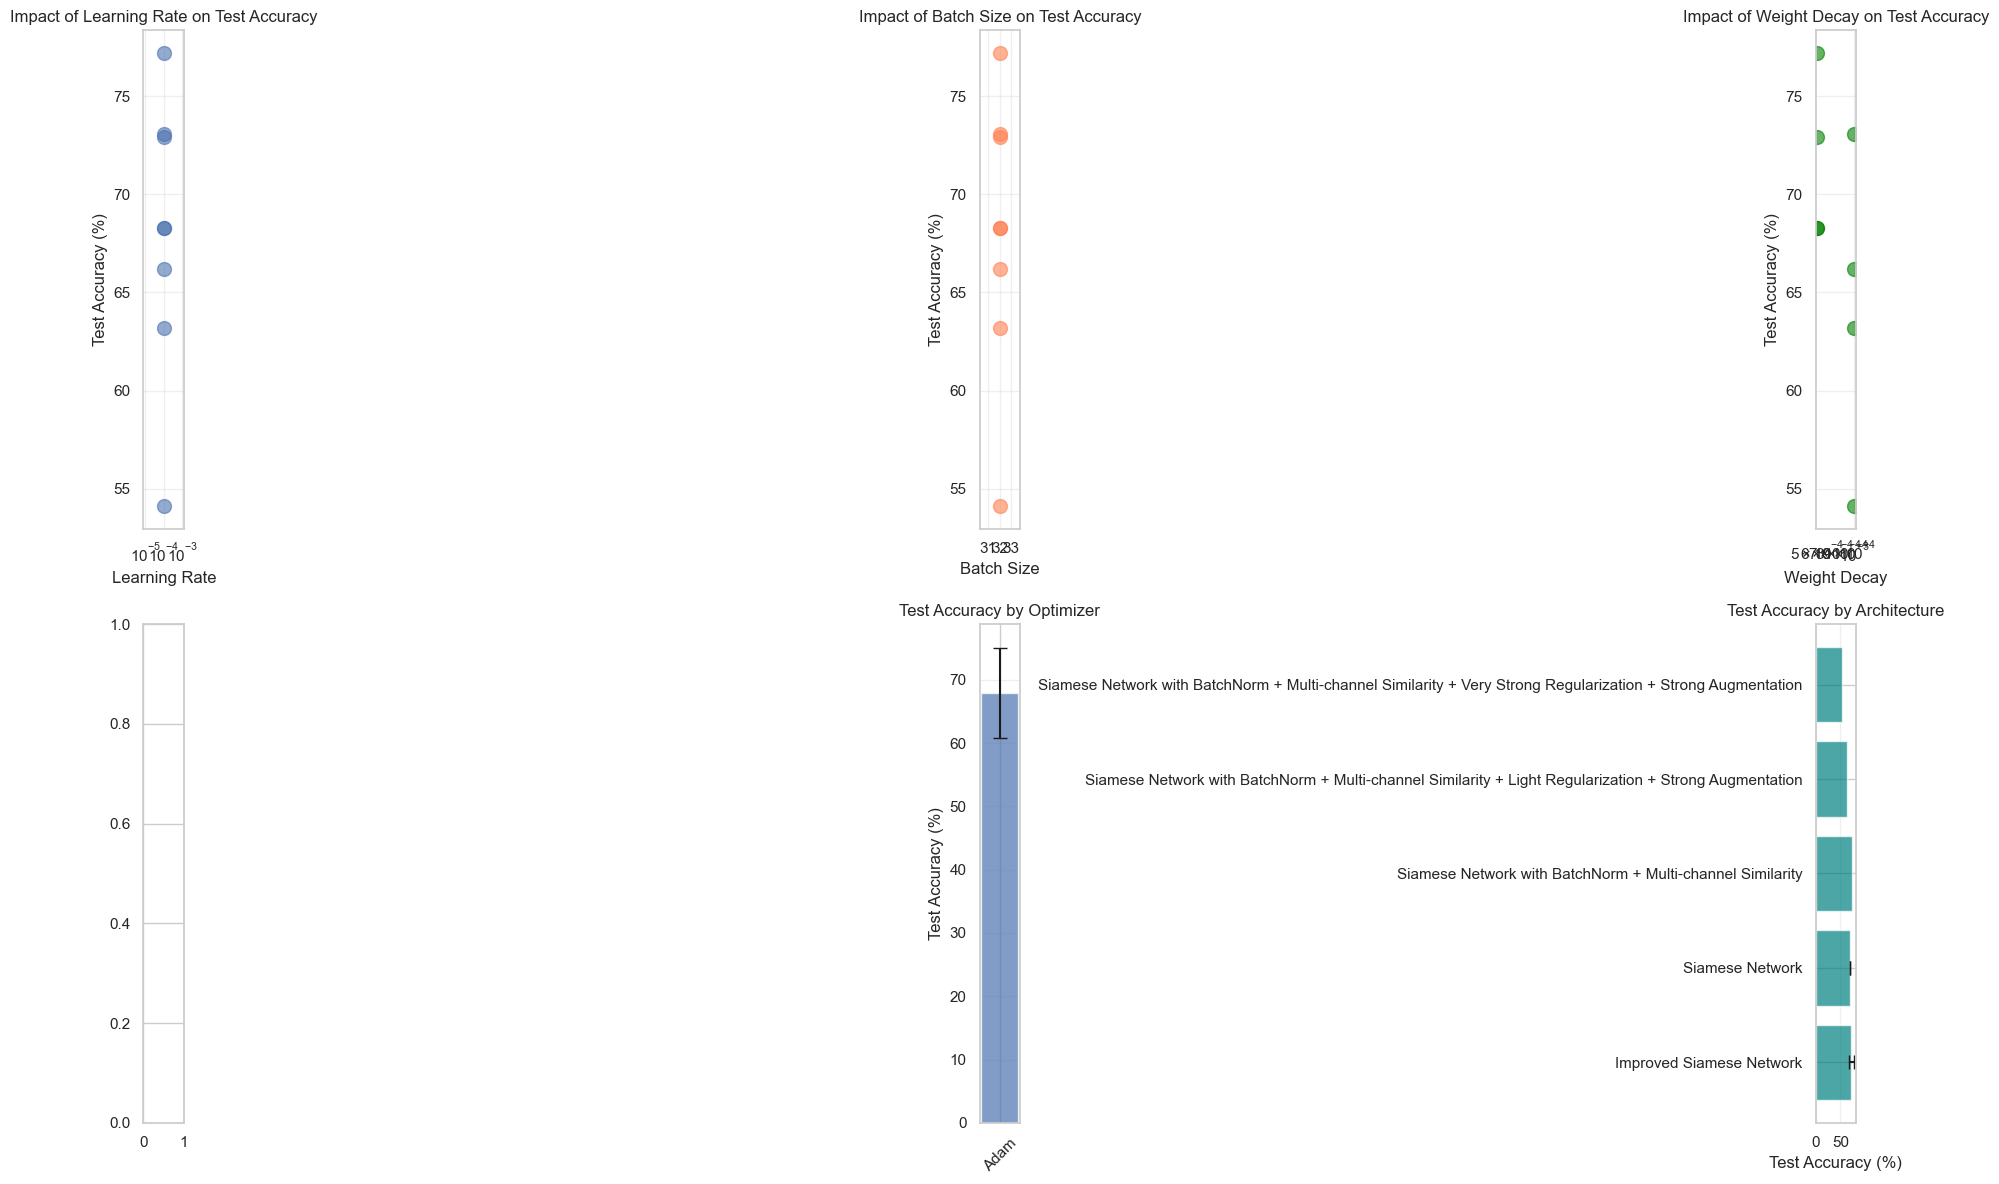

In [ ]:
# Plot metrics with different hyperparameters across runs
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# Sort by run_id for chronological order
df_sorted = df.sort_values('run_id').reset_index(drop=True)
run_numbers = range(1, len(df_sorted) + 1)

# 1. Learning Rate across runs
lr_df = df_sorted[df_sorted['learning_rate'].notna()]
if not lr_df.empty:
    lr_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'learning_rate'] == df_sorted.loc[idx, 'learning_rate']]
    axes[0, 0].plot(lr_run_nums, lr_df['learning_rate'], marker='o', linewidth=2, label='Learning Rate', color='#1B4965')
    ax2 = axes[0, 0].twinx()
    ax2.plot(lr_run_nums, lr_df['test_acc'], marker='s', linewidth=2, label='Test Acc', color='#E63946', alpha=0.7)
    axes[0, 0].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[0, 0].set_ylabel('Learning Rate', fontsize=12, color='#1B4965')
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12, color='#E63946')
    axes[0, 0].set_title('Learning Rate & Test Accuracy Across Runs', fontsize=14, fontweight='bold')
    axes[0, 0].tick_params(axis='y', labelcolor='#1B4965')
    ax2.tick_params(axis='y', labelcolor='#E63946')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)

# 2. Batch Size across runs
bs_df = df_sorted[df_sorted['batch_size'].notna()]
if not bs_df.empty:
    bs_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'batch_size'] == df_sorted.loc[idx, 'batch_size']]
    axes[0, 1].plot(bs_run_nums, bs_df['batch_size'], marker='o', linewidth=2, label='Batch Size', color='#457B9D')
    ax2 = axes[0, 1].twinx()
    ax2.plot(bs_run_nums, bs_df['test_acc'], marker='s', linewidth=2, label='Test Acc', color='#F77F00', alpha=0.7)
    axes[0, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[0, 1].set_ylabel('Batch Size', fontsize=12, color='#457B9D')
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12, color='#F77F00')
    axes[0, 1].set_title('Batch Size & Test Accuracy Across Runs', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='y', labelcolor='#457B9D')
    ax2.tick_params(axis='y', labelcolor='#F77F00')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Weight Decay across runs
wd_df = df_sorted[df_sorted['weight_decay'].notna()]
if not wd_df.empty:
    wd_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'weight_decay'] == df_sorted.loc[idx, 'weight_decay']]
    axes[1, 0].plot(wd_run_nums, wd_df['weight_decay'], marker='o', linewidth=2, label='Weight Decay', color='#06A77D')
    ax2 = axes[1, 0].twinx()
    ax2.plot(wd_run_nums, wd_df['test_acc'], marker='s', linewidth=2, label='Test Acc', color='#D62828', alpha=0.7)
    axes[1, 0].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[1, 0].set_ylabel('Weight Decay', fontsize=12, color='#06A77D')
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12, color='#D62828')
    axes[1, 0].set_title('Weight Decay & Test Accuracy Across Runs', fontsize=14, fontweight='bold')
    axes[1, 0].tick_params(axis='y', labelcolor='#06A77D')
    ax2.tick_params(axis='y', labelcolor='#D62828')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Train vs Val vs Test Accuracy across runs
axes[1, 1].plot(run_numbers, df_sorted['test_acc'], marker='o', linewidth=2, markersize=6, label='Test Acc', color='#2E86AB')
train_df = df_sorted[df_sorted['train_acc'].notna()]
if not train_df.empty:
    train_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'train_acc'] == df_sorted.loc[idx, 'train_acc']]
    axes[1, 1].plot(train_run_nums, train_df['train_acc'], marker='^', linewidth=2, markersize=6, label='Train Acc', color='#06A77D')
val_df = df_sorted[df_sorted['val_acc'].notna()]
if not val_df.empty:
    val_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'val_acc'] == df_sorted.loc[idx, 'val_acc']]
    axes[1, 1].plot(val_run_nums, val_df['val_acc'], marker='s', linewidth=2, markersize=6, label='Val Acc', color='#F77F00')
axes[1, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 1].set_title('Train/Val/Test Accuracy Across Runs', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Train vs Test Loss across runs
axes[2, 0].plot(run_numbers, df_sorted['test_loss'], marker='o', linewidth=2, markersize=6, label='Test Loss', color='#A23B72')
train_loss_df = df_sorted[df_sorted['train_loss'].notna()]
if not train_loss_df.empty:
    train_loss_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'train_loss'] == df_sorted.loc[idx, 'train_loss']]
    axes[2, 0].plot(train_loss_run_nums, train_loss_df['train_loss'], marker='^', linewidth=2, markersize=6, label='Train Loss', color='#219EBC')
val_loss_df = df_sorted[df_sorted['val_loss'].notna()]
if not val_loss_df.empty:
    val_loss_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'val_loss'] == df_sorted.loc[idx, 'val_loss']]
    axes[2, 0].plot(val_loss_run_nums, val_loss_df['val_loss'], marker='s', linewidth=2, markersize=6, label='Val Loss', color='#FB8500')
axes[2, 0].set_xlabel('Run Number (Chronological)', fontsize=12)
axes[2, 0].set_ylabel('Loss', fontsize=12)
axes[2, 0].set_title('Train/Val/Test Loss Across Runs', fontsize=14, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Best Validation Accuracy across runs
best_val_df = df_sorted[df_sorted['best_val_acc'].notna()]
if not best_val_df.empty:
    best_val_run_nums = [i+1 for i, idx in enumerate(df_sorted.index) if df_sorted.loc[idx, 'best_val_acc'] == df_sorted.loc[idx, 'best_val_acc']]
    axes[2, 1].plot(best_val_run_nums, best_val_df['best_val_acc'], marker='o', linewidth=2, markersize=8, label='Best Val Acc', color='#8338EC')
    axes[2, 1].plot(run_numbers, df_sorted['test_acc'], marker='s', linewidth=2, markersize=6, label='Test Acc', color='#06A77D', alpha=0.7)
    axes[2, 1].set_xlabel('Run Number (Chronological)', fontsize=12)
    axes[2, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[2, 1].set_title('Best Val Accuracy vs Test Accuracy Across Runs', fontsize=14, fontweight='bold')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Show top 5 best performing configurations
print("\n=== Top 5 Best Performing Runs ===")
top_5 = df.nlargest(5, 'test_acc')[['run_id', 'test_acc', 'test_loss', 'best_val_acc', 
                                      'learning_rate', 'batch_size', 'dropout', 'optimizer']]
print(top_5.to_string(index=False))

# Correlation analysis
print("\n=== Correlation with Test Accuracy ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()['test_acc'].sort_values(ascending=False)
print(correlations[correlations.index != 'test_acc'])


=== Top 5 Best Performing Runs ===
                      run_id  test_acc  test_loss  best_val_acc  learning_rate  batch_size                                      dropout optimizer
run-20251219_193848-hqnw88ut      77.2   0.701974     79.545455         0.0001          32                                         None      Adam
run-20251222_185539-e0bibsan      73.1   0.531361     77.272727         0.0001          32 0.5 (embedding) / 0.5, 0.4 (similarity head)      Adam
run-20251219_183432-9ou6x57u      72.9   0.816390     75.000000         0.0001          32                                         None      Adam
run-20251215_150045-fg3yp8lj      68.3   0.590051     69.772727         0.0001          32                                         None      Adam
run-20251219_192927-rcjzlbbw      68.3   0.590051     69.772727         0.0001          32                                         None      Adam

=== Correlation with Test Accuracy ===
val_acc          0.989956
best_val_acc     0.985

In [7]:
# Save summary to CSV
summary_df = df[['run_id', 'test_acc', 'test_loss', 'val_acc', 'best_val_acc', 
                  'learning_rate', 'batch_size', 'dropout', 'weight_decay', 
                  'optimizer', 'architecture', 'runtime']]
summary_df.to_csv('results/runs_analysis_summary.csv', index=False)
print("\nSummary saved to results/runs_analysis_summary.csv")


Summary saved to results/runs_analysis_summary.csv
